In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pip install split-folders

In [0]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import split_folders
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
!unzip '/content/drive/My Drive/VR/Dress Recognition/cropped_images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: cropped_images/saree/1048.png  
  inflating: cropped_images/saree/1049.png  
  inflating: cropped_images/saree/105.png  
  inflating: cropped_images/saree/527.png  
  inflating: cropped_images/saree/532.png  
  inflating: cropped_images/saree/535.png  
  inflating: cropped_images/saree/537.png  
  inflating: cropped_images/saree/1052.png  
  inflating: cropped_images/saree/1053.png  
  inflating: cropped_images/saree/1987.png  
  inflating: cropped_images/saree/1988.png  
  inflating: cropped_images/saree/1989.png  
  inflating: cropped_images/saree/199.png  
  inflating: cropped_images/saree/1990.png  
  inflating: cropped_images/saree/1991.png  
  inflating: cropped_images/saree/1992.png  
  inflating: cropped_images/saree/1993.png  
  inflating: cropped_images/saree/1994.png  
  inflating: cropped_images/saree/1995.png  
  inflating: cropped_images/saree/1996.png  
  inflating: cropped_images/saree/1997.png  
  inflatin

In [0]:
split_folders.ratio('cropped_images', output="output", seed=1337, ratio= (.8,.2)) # default values

Copying files: 6383 files [00:02, 2886.43 files/s]


In [0]:
train_path = '/content/output/train/'
valid_path = '/content/output/val/'

In [0]:
# Image size should be [224,224]
# Iterate through each color folder

def resize_images(image_dir):
  image_types = ["kurti","none","saree","shirt","tshirt"]
  for im_type in image_types:
    # Iterate through each image file in each image_type folder
    #  glob reads in any image with the extension "image_dir/im_type/*"
    for file in glob.glob(os.path.join(image_dir, im_type, "*")):
        im = Image.open(file)
        f, e = os.path.splitext(file)
        imResize = im.resize((224,224), Image.ANTIALIAS)
        imResize.save(f + '.png', 'PNG', quality=90)

resize_images('/content/output/val')
resize_images('/content/output/train')

In [0]:
image_size = [224,224]
num_classes = 5
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=image_size + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 3s 0us/step


In [0]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(num_classes, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [0]:
training_set = train_datagen.flow_from_directory('/content/output/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5105 images belonging to 5 classes.


In [0]:
validation_set = val_datagen.flow_from_directory('/content/output/val/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1278 images belonging to 5 classes.


In [0]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/10
160/160 [==============================] - 82s 515ms/step - loss: 0.8583 - accuracy: 0.6929 - val_loss: 0.4408 - val_accuracy: 0.8020
Epoch 2/10
160/160 [==============================] - 72s 448ms/step - loss: 0.4918 - accuracy: 0.8259 - val_loss: 0.5679 - val_accuracy: 0.8106
Epoch 3/10
160/160 [==============================] - 72s 451ms/step - loss: 0.4269 - accuracy: 0.8454 - val_loss: 0.5713 - val_accuracy: 0.8232
Epoch 4/10
160/160 [==============================] - 73s 454ms/step - loss: 0.3558 - accuracy: 0.8686 - val_loss: 0.6981 - val_accuracy: 0.8130
Epoch 5/10
160/160 [==============================] - 73s 454ms/step - loss: 0.2878 - accuracy: 0.8927 - val_loss: 0.2994 - val_accuracy: 0.7864
Epoch 6/10
160/160 [==============================] - 73s 456ms/step - loss: 0.2961 - accuracy: 0.8923 - val_loss: 0.4095 - val_accuracy: 0.8326
Epoch 7/10
160/160 [==============================] - 72s 449ms/step - loss: 0.2252 - accuracy: 0.9193 - val_loss: 1.0229 - val_ac

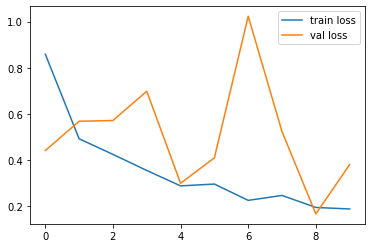

<Figure size 432x288 with 0 Axes>

In [0]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

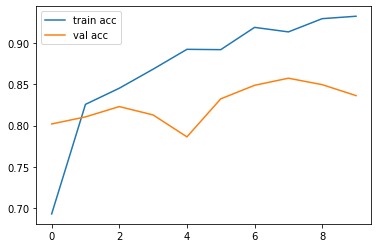

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [0]:
# model.save_weights('pre_trained_resnet.h5')